![logo](../../picture/license_header_logo.png)
> **Copyright (c) 2020-2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful,
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

# Requirement
You should complete the LSTM tutorial before starting the CNN tutorial. This is because most of the functions used will be based on `data_module.py` and `deep_learning_module.py`

Please proceed to the LSTM notebook if you haven't complete it.<br>

1. [04 - LSTM_Univariate_SingleStep](./04%20-%20LSTM_Univariate_SingleStep.ipynb)
2. [04 - LSTM_Univariate_MultiStep.ipynb](./04%20-%20LSTM_Univariate_MultiStep.ipynb)
3. [04 - LSTM_Multivariate_Univariate_SingleStep](./04%20-%20LSTM_Multivariate_Univariate_SingleStep.ipynb)<br>
4. [04 - LSTM_Multivariate_Univariate_MultiStep](./04%20-%20LSTM_Multivariate_Univariate_MultiStep.ipynb)<br>

## Univariate CNN Multi-Step
This tutorial is to demonstrate the process to build CNN for the Univariate time series for Multi-Step Forecast.<br>

It consists of 2 major parts which are:<br>

Part 1 - The Demonstration of Building CNN using Synthetic data <br>
Part 2 - Exercise of building CNN using minimum daily temperatures in  city Melbourne, Australia. <br> 

>**Instruction** :<br>
You are required to complete the exercise after the demonstration.<br>
We will use the functions in `data_module.py` and `deep_learning_module.py` to complete this tutorial.

## What will we accomplish?
First, we will show the step in building the CNN :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data)<br>
Step 2. Model Configuration for CNN<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

Let's import the package needed.

In [1]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import math
import matplotlib.dates as mdates 
from torchsummaryX import summary

# To auto load the customise module
%load_ext autoreload
%autoreload 2
import deep_learning_module
import data_module

# Part 1 : Demonstration of Building CNN using Synthetic data

## Hyperparameter

Define the hyperparameter that is needed to tune the model.

In [2]:
split_ratio = 0.70
num_epochs = 60
window_size = 6
batch_size = 5
n_step = 2
learning_rate = 0.001
# seed
torch.manual_seed(123)

# Step 1 : Data Preparation
We create synthetic data to make sure the model is created correctly and has the ability to perform forecasting. <br>

1. First, we will create a sequence of data with `np.array`.
2. Then, we will assign a date to the sequence of data with `pd.date_range` and store it in a series format by using `pd.Series`.

In [3]:
# Create Synthetic Data
univariate_series = np.array([x for x in range(0, 400, 10)])
print(univariate_series.shape)
univariate_series

(40,)


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390])

In [4]:
# Create time index for Synthetic Data
univariate_series =pd.Series(univariate_series,pd.date_range("1/1/2020",
                                                             periods=len(univariate_series),
                                                            freq='D'))
univariate_series.head()

2020-01-01     0
2020-01-02    10
2020-01-03    20
2020-01-04    30
2020-01-05    40
Freq: D, dtype: int32

## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality. As seen in the graph below, there is an increasing trend in data.

Text(0.5, 1.0, 'Synthetic Data')

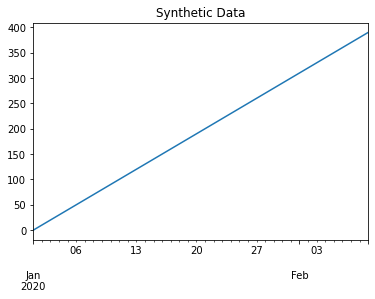

In [5]:
univariate_series.plot()
plt.title("Synthetic Data")

## Data Splitting
In Deep Learning, we will split the data into training and test dataset.The training data is used to train the model where the test data is used to validate the performance of the model

In [6]:
# Split the data with ratio as state in hyperparameter
split_data = round(len(univariate_series)*split_ratio)
split_data

28

In [7]:
# Split data by indexing 
train_data = univariate_series.values[:split_data]
test_data = univariate_series.values[split_data:]
train_time = univariate_series.index[:split_data]
test_time = univariate_series.index[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(28,)
test_data_shape
(12,)


## Data Standardization
Standardize the data to have 0 mean and unit variance to make our model converge faster.

In [8]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))

test_data_standard = scaler.transform(test_data.reshape(-1, 1))

## Data Sequencing
Sequencing the data by taking in the univariate series into `x-feature` and `y-label`
<img src = "../../picture/Data Sequencing in Univariate Multi-step.png"  width="300" height  ="300" align="center" />

In [9]:
trainX, trainY = data_module.univariate_multi_step(train_data_standard, window_size, n_step)
testX, testY = data_module.univariate_multi_step(test_data_standard, window_size, n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testX shape:{testY.shape}")

trainX shape:(21, 6, 1) trainY shape:(21, 2, 1)

testX shape:(5, 6, 1) testX shape:(5, 2, 1)


In [10]:
trainY = trainY.reshape(trainY.shape[0],n_step,1)
testY = testY.reshape(testY.shape[0],n_step,1)
print(f"trainY shape:{trainY.shape}")
print(f"testY shape:{testY.shape}")

trainY shape:(21, 2, 1)
testY shape:(5, 2, 1)


## Data Transform
Data needs to be transformed from `NumPy` to `PyTorch` tensor before being fed into the model

In [11]:

train_data_dict ,test_data_dict = data_module.key_assign(trainingX = trainX  , 
                       testingX = testX, 
                       trainingY = trainY, 
                       testingY = testY)


train_data_dict ,test_data_dict = data_module.transform(train_data_dict ,test_data_dict)


In [12]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([21, 6, 1])
train_data_y_label shape : torch.Size([21, 2, 1])
test_data_x_feature shape : torch.Size([5, 6, 1])
test_data_y_label shape : torch.Size([5, 2, 1])


## Data Transpose 
You are required to transpose the x-feature data in such a way that : <br>
>`(batch_size, number_of_features, sequence_length)`.

In [13]:
# Data Transpose to suit for CNN 
train_data_dict , test_data_dict= data_module.transpose(train_data_dict,test_data_dict)

In [14]:
data_module.sanity_check(train_data_dict , test_data_dict)

train_data_x_feature shape : torch.Size([21, 1, 6])
train_data_y_label shape : torch.Size([21, 2, 1])
test_data_x_feature shape : torch.Size([5, 1, 6])
test_data_y_label shape : torch.Size([5, 2, 1])


## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process

In [15]:

train_iter , test_iter = data_module.iterator(train_data_dict ,test_data_dict,batch_size = batch_size)


# Step 2 :  CNN Model Configuration
You may choose to use the CNN configuration that have been saved in the `deep_learning_module.py` or code it by yourself. For demonstration purposes, we will use the CNN configuration in `deep_learning_module.py`

## Input Model
The number of features and number of steps are fed as attributes into the model. The other attributes such as `kernel_size` , `in_channels` and `out_channels` for each convolution layer need to configured in the network configuration by the practitioner.

In [16]:
# seed
torch.manual_seed(123)
n_feature = train_data_dict['train_data_x_feature'].shape[1]

# Input the attribute need by the model 
model = deep_learning_module.CNN(n_feature = n_feature,n_step = n_step )

# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()



In [17]:
seq_length = train_data_dict['train_data_x_feature'].shape[2]
inputs = torch.zeros((batch_size,n_feature ,seq_length),dtype=torch.float) # batch size ,input_dim ,seq_length
print(summary(model,inputs))

        Kernel Shape Output Shape Params Mult-Adds
Layer                                             
0_conv1   [1, 30, 3]   [5, 30, 4]  120.0     360.0
1_poo1             -   [5, 30, 2]      -         -
2_conv2  [30, 20, 2]   [5, 20, 1]  1.22k      1.2k
3_pool2            -   [5, 20, 1]      -         -
4_fc1       [20, 10]      [5, 10]  210.0     200.0
5_fc2        [10, 2]       [5, 2]   22.0      20.0
----------------------------------------------------
                      Totals
Total params          1.572k
Trainable params      1.572k
Non-trainable params     0.0
Mult-Adds              1.78k
        Kernel Shape Output Shape  Params  Mult-Adds
Layer                                               
0_conv1   [1, 30, 3]   [5, 30, 4]   120.0      360.0
1_poo1             -   [5, 30, 2]     NaN        NaN
2_conv2  [30, 20, 2]   [5, 20, 1]  1220.0     1200.0
3_pool2            -   [5, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [5, 10]   210.0      200.0
5_fc2        [10, 2]   

In [18]:
# seed
torch.manual_seed(123)

#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(3,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

# Step 3 : Training

In [19]:
# seed
torch.manual_seed(123)
# Start Training
train_loss, val_loss = deep_learning_module.training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

# Step 4 : Validation 
A learning curve is plotted to define how well the data fits in the model 

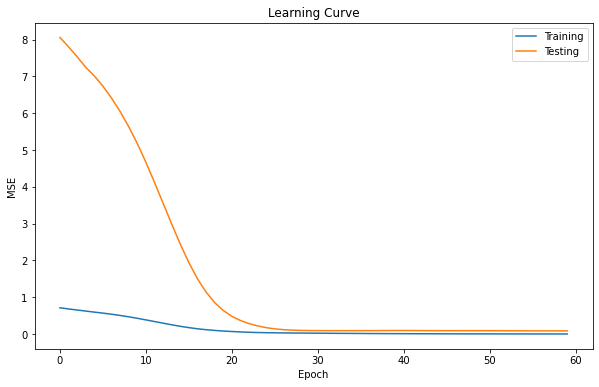

Epoch : 0 , training loss : 0.7136811880128724 , validation loss : 8.05888557434082
Epoch : 1 , training loss : 0.6815902626230603 , validation loss : 7.805926322937012
Epoch : 2 , training loss : 0.6529634887618678 , validation loss : 7.534052848815918
Epoch : 3 , training loss : 0.6242329323043426 , validation loss : 7.248782157897949
Epoch : 4 , training loss : 0.5955341687159879 , validation loss : 7.013446807861328
Epoch : 5 , training loss : 0.568481149329316 , validation loss : 6.734824180603027
Epoch : 6 , training loss : 0.5384398195892572 , validation loss : 6.412732124328613
Epoch : 7 , training loss : 0.504943114661035 , validation loss : 6.046242713928223
Epoch : 8 , training loss : 0.46775781522904125 , validation loss : 5.634289741516113
Epoch : 9 , training loss : 0.4273449819357622 , validation loss : 5.174464225769043
Epoch : 10 , training loss : 0.384307965104069 , validation loss : 4.66737174987793
Epoch : 11 , training loss : 0.3397886623584089 , validation loss : 

In [20]:
data_module.learning_curve(num_epochs = num_epochs , train_loss = train_loss , val_loss = val_loss )

# Step 5 : Evaluation
This section is to inference the model by feeding in testing data, determining the output forecast value and calculating the RMSE.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

In [21]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(train_data_dict['train_data_x_feature'])
    y_test_prediction = model(test_data_dict['test_data_x_feature'])

In [22]:
# Assign evaluation key

prediction , output = data_module.key_assign_evaluation(y_train_prediction,
                                                        y_test_prediction,
                                                        train_data_dict,
                                                        test_data_dict)
# Section 2 : Reshape to original data
# Squeeze the output dimension
output_data = data_module.squeeze_dimension(output)


In [23]:
data_module.sanity_check(data_1 = output_data,data_2 = {})

train_data_output shape : torch.Size([21, 2])
test_data_output shape : torch.Size([5, 2])


In [24]:
# Section 3 : Invert the scaling back to the original data value
prediction = data_module.inverse_scaler(prediction,scaler)
output_data  = data_module.inverse_scaler(output_data ,scaler)

In [25]:
data_module.sanity_check(data_1 = prediction,data_2 = output_data )

train_data_prediction shape : (21, 2)
test_data_prediction shape : (5, 2)
train_data_output shape : (21, 2)
test_data_output shape : (5, 2)


In [26]:
# List the forecast value
data_module.list_forecast_value(output_data,prediction) 

Test Data			Forecast
[340. 350.]		[321.81134 330.3452 ]
[350. 360.]		[329.58838 338.08304]
[360. 370.]		[337.3614 345.8332]
[370. 380.]		[345.08624 353.60135]
[380. 390.]		[352.8111  361.36957]


In [27]:
# Section 4 : Calculate the RMSE of train and test data
### BEGIN SOLUTION
trainScore,testScore = data_module.rmse(prediction,output_data)
### END SOLUTION
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.22 RMSE
Test Score: 23.64 RMSE


# Step 6 : Forecast Plot

In [28]:
plot_details ={"x-axis" : "Day",
          "y-axis" : "Values",
          "title"  : "Synthetic Data"
         }

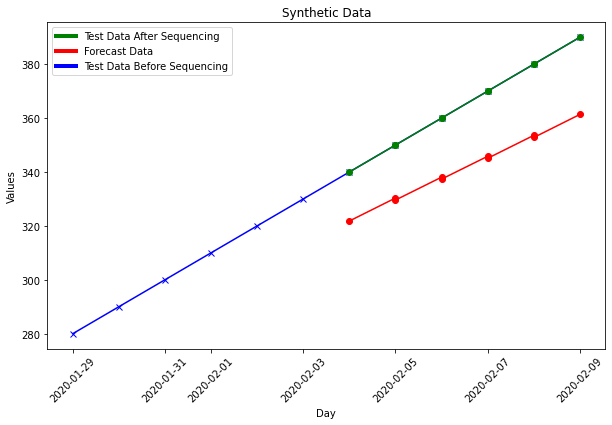

In [29]:
# Use the multi_step_plot function
data_module.multi_step_plot(original_test_data = test_data,
                after_sequence_test_data = output_data ,
                forecast_data = prediction,
                test_time = test_time,
                window_size = window_size ,
                n_step = n_step,
                details = plot_details,
                original_plot = True)

# Part 2 : Exercise for Univariate Multi-step

## Task : Use CNN to predict the temperature for Melbourne

### Introduction
You are given a set of dataset that describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.The units are in degrees Celsius and there are 3650 observations.

### Data Sources :
[The source of the data is credited as the Australian Bureau of Meteorology.](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv)

## Hyperparameter
>**Instruction** : <br>
You are required to fill `None` with a suitable value to make the model converge

>**Expected Result** : <br>
Train Score <= 10 RMSE<br>
Test Score <= 10 RMSE<br>

In [30]:
#Hyperparameter
num_epochs_temperature = 100
batch_size_temperature = 30
window_size_temperature = 20
learning_rate_temperature = 0.001
n_step_temperature = 2 

# Step 1 : Data Preparation
>**Instruction** : <br>
Read the `CSV` file using `pd.read_csv`<br>
Your file path `https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv`

>**Expected Result** : <br>
Example of the first 5 rows of data:

---|	Date|	Temp
---|---|---
0|	1981-01-01|	20.7
1|	1981-01-02|	17.9
2|	1981-01-03|	18.8
3|	1981-01-04|	14.6
4|	1981-01-05|	15.8

In [31]:
# Read CSV file 
### BEGIN SOLUTION
temperature = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
### END SOLUTION
temperature.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


>**Instruction** : <br>
Convert the `Date` by using `pd.to_datetime`
Set the index as 'Date' using `df.set_index`

>**Expected Result** : <br>
Example of the first 5 rows:

Date|	Temp
---|---
1981-01-01|	20.7
1981-01-02|	17.9
1981-01-03|	18.8
1981-01-04|	14.6
1981-01-05|	15.8

In [32]:
### BEGIN SOLUTION
temperature['Date'] = pd.to_datetime(temperature['Date'])
temperature = temperature.set_index('Date')
### END SOLUTION
temperature.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


>**Instruction** : <br>
Save the data in `Series` format using `pd.Series`

>**Expected Result** : <br>
Example of the first 5 data

Date|---
---|---
1981-01-01|    20.7
1981-01-02|    17.9
1981-01-03|    18.8
1981-01-04|    14.6
1981-01-05|    15.8

In [33]:
### BEGIN SOLUTION
temperature_ts = pd.Series(temperature['Temp'])
### END SOLUTION
temperature_ts.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

## Data Visualization
Data visualization is important for us to visualize the pattern of data such as trend and seasonality.
>**Instruction** : <br>
Use `df.plot()` to plot the `temperature_ts`

<AxesSubplot:xlabel='Date'>

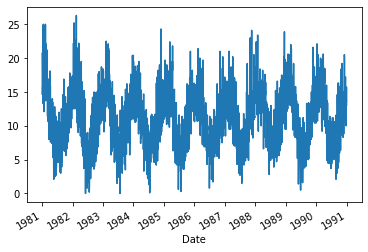

In [34]:
### BEGIN SOLUTION
temperature_ts.plot()
### END SOLUTION

## Data Splitting

In [35]:
# Create split data ratio
split_data = 0.6
split_ratio = round(len(temperature_ts)*split_data)

In [36]:
# Split data by indexing 
train_data_temperature= temperature_ts[:split_ratio]
test_data_temperature = temperature_ts[split_ratio:]
train_time_temperature = temperature_ts.index[:split_ratio ]
test_time_temperature = temperature_ts.index[split_ratio:]
print("train_data_shampoo_shape")
print(train_data_temperature.shape)
print("test_data_shampoo_shape")
print(test_data_temperature.shape)

train_data_shampoo_shape
(2190,)
test_data_shampoo_shape
(1460,)


## Data Standardization
>**Instruction** : <br>
Use `StandardScaler()` to  standardize the data, save your data scaler into `scaler_temperature`.<br>
Train and test scaled data into `scaler_train_shampoo_data ` and `test_data_scaled_temperature`.<br>

Example :<br>
`train_data_scaled_temperature = scaler_temperature.transform(train_data_temperature.values.reshape(-1, 1))`

In [37]:
### BEGIN SOLUTION
scaler_temperature = StandardScaler().fit(train_data_temperature.values.reshape(-1, 1))
train_data_scaled_temperature = scaler_temperature.transform(train_data_temperature.values.reshape(-1, 1))
test_data_scaled_temperature = scaler_temperature.transform(test_data_temperature.values.reshape((-1, 1)))
### END SOLUTION

## Data Sequencing 
>**Instruction** : <br>
Use `data_module.univariate_multi_step` to perform sliding window operation by taking the scaled data and save your data into respective `x` and `y` variable.<br>
Example :<br>
`trainX_temperature ,trainY_temperature =  data_module.univariate_multi_step(train_data_scaled_temperature,
                                                                             window_size_temperature)`

In [38]:
### BEGIN SOLUTION
trainX_temperature ,trainY_temperature =  data_module.univariate_multi_step(train_data_scaled_temperature,
                                                                             window_size_temperature,
                                                                             n_step_temperature)

testX_temperature , testY_temperature = data_module.univariate_multi_step(test_data_scaled_temperature,
                                                                           window_size_temperature,
                                                                          n_step_temperature)
### END SOLUTION
print(f"trainX shape:{trainX_temperature.shape} trainY shape:{trainY_temperature.shape}\n")
print(f"testX shape:{testX_temperature.shape} testX shape:{testY_temperature.shape}")

trainX shape:(2169, 20, 1) trainY shape:(2169, 2, 1)

testX shape:(1439, 20, 1) testX shape:(1439, 2, 1)


In [39]:
trainY_temperature= trainY_temperature.reshape(trainY_temperature.shape[0],n_step,1)
testY_temperature= testY_temperature.reshape(testY_temperature.shape[0],n_step,1)
print(f"trainY shape:{trainY_temperature.shape}")
print(f"testY shape:{testY_temperature.shape}")

trainY shape:(2169, 2, 1)
testY shape:(1439, 2, 1)


### Data Transform
Data needs to be transformed from numpy to pytorch tensor before being fed into the model.

>**Instruction** : <br>
Use `data_module.key_assign` to assign the key and `data_module.transform` to transform the data.

In [40]:
# Key Assign 
### BEGIN SOLUTION
train_data_dict_temperature ,test_data_dict_temperature = data_module.key_assign(trainingX = trainX_temperature  , 
                       testingX = testX_temperature, 
                       trainingY = trainY_temperature, 
                       testingY = testY_temperature)
### END SOLUTION

# Transform data
### BEGIN SOLUTION
train_data_dict_temperature ,test_data_dict_temperature= data_module.transform(train_data_dict_temperature ,
                                                                          test_data_dict_temperature)
### END SOLUTION

## Data Transpose 
You are required to transpose the x-feature data in such a way that : <br>
>`(batch_size, number_of_features, sequence_length)`.



>**Instruction** : <br>
Use `transpose` function in `data_module.py` to transpose the suitable input data for CNN model.

In [41]:
### BEGIN SOLUTION
train_data_dict_temperature , test_data_dict_temperature = data_module.transpose(train_data_dict_temperature,
                                                                     test_data_dict_temperature)
### END SOLUTION

## Data Iterator
Iterator is created to separate the data into several batches to fasten the training process.
>**Instruction** : <br>
Use `data_module.iterator` to create data iterator.

In [42]:
# Create Iterator
train_iter_temperature , test_iter_temperature = data_module.iterator(train_data_dict_temperature ,
                                                                      test_data_dict_temperature,
                                                                      batch_size = batch_size_temperature)

# Step 2 :  CNN Model Configuration

You may choose to use the CNN configuration that have been saved in the `deep_learning_module.py` or code it by yourself.

## Input Model



>**Instruction** : <br>
Input the model that you have configured, use `Adam` as the optimizer and `MSE` as the loss function

In [43]:
# seed
torch.manual_seed(123)

n_feature_temperature = train_data_dict_temperature['train_data_x_feature'].shape[1]
### BEGIN SOLUTION
# Input the attribute need by the model 
model_temperature = deep_learning_module.CNN(n_feature = n_feature_temperature,
                        n_step = n_step_temperature )

### END SOLUTION
# Define the optimizer (Here we use Adam as our optimizer)

### BEGIN SOLUTION
optimizer_temperature = torch.optim.Adam(model_temperature.parameters(), lr=learning_rate_temperature)
### END SOLUTION

# Define the loss function (Here we use MSE as the loss function)
### BEGIN SOLUTION
loss_fn_temperature = nn.MSELoss()
### END SOLUTION

In [44]:
seq_length_temperature = train_data_dict_temperature['train_data_x_feature'].shape[2]

# batch size ,input_dim ,seq_length
inputs = torch.zeros((batch_size_temperature,
                      n_feature_temperature ,
                      seq_length_temperature),dtype=torch.float) 

print(summary(model_temperature,inputs))

        Kernel Shape  Output Shape Params Mult-Adds
Layer                                              
0_conv1   [1, 30, 3]  [30, 30, 18]  120.0     1.62k
1_poo1             -   [30, 30, 9]      -         -
2_conv2  [30, 20, 2]   [30, 20, 8]  1.22k      9.6k
3_pool2            -   [30, 20, 1]      -         -
4_fc1       [20, 10]      [30, 10]  210.0     200.0
5_fc2        [10, 2]       [30, 2]   22.0      20.0
-----------------------------------------------------
                      Totals
Total params          1.572k
Trainable params      1.572k
Non-trainable params     0.0
Mult-Adds             11.44k
        Kernel Shape  Output Shape  Params  Mult-Adds
Layer                                                
0_conv1   [1, 30, 3]  [30, 30, 18]   120.0     1620.0
1_poo1             -   [30, 30, 9]     NaN        NaN
2_conv2  [30, 20, 2]   [30, 20, 8]  1220.0     9600.0
3_pool2            -   [30, 20, 1]     NaN        NaN
4_fc1       [20, 10]      [30, 10]   210.0      200.0
5_fc2  

In [45]:
torch.manual_seed(123)

# Xavier weight intialization
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)
        
model_temperature.apply(weights_init)

CNN(
  (conv1): Conv1d(1, 30, kernel_size=(3,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(30, 20, kernel_size=(2,), stride=(1,))
  (pool2): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=20, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

# Step 3 : Training

In [46]:
# seed
torch.manual_seed(123)
# Start Training 
train_loss_temperature,val_loss_temperature = deep_learning_module.training(num_epochs_temperature,
                                                                            train_iter_temperature,
                                                                            test_iter_temperature,
                                                                            optimizer_temperature,
                                                                            loss_fn_temperature,
                                                                            model_temperature)

# Step 4 : Validation
Plot the learning curve to evaluate the loss of each epoch 

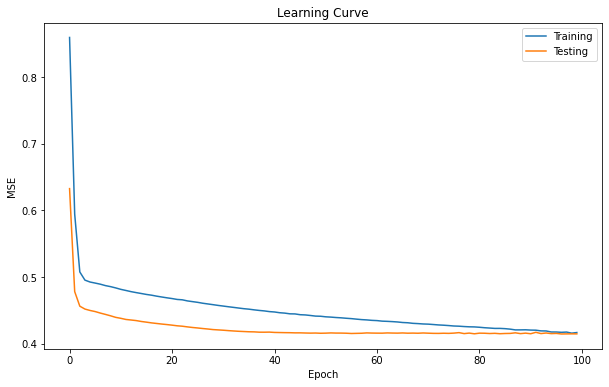

Epoch : 0 , training loss : 0.8598064747259 , validation loss : 0.6328215526780625
Epoch : 1 , training loss : 0.5945026074042788 , validation loss : 0.4781317098882979
Epoch : 2 , training loss : 0.5076663146622448 , validation loss : 0.45626757700381965
Epoch : 3 , training loss : 0.49539222616707473 , validation loss : 0.45194610040000616
Epoch : 4 , training loss : 0.49254063756963856 , validation loss : 0.4498298286853191
Epoch : 5 , training loss : 0.49096693009921294 , validation loss : 0.4481864304613785
Epoch : 6 , training loss : 0.489298905739316 , validation loss : 0.445915606967934
Epoch : 7 , training loss : 0.487166389266485 , validation loss : 0.4439290274423887
Epoch : 8 , training loss : 0.4856260746181588 , validation loss : 0.4418190135940899
Epoch : 9 , training loss : 0.4837135081469271 , validation loss : 0.4394889740872665
Epoch : 10 , training loss : 0.4815478547067893 , validation loss : 0.4380538279269618
Epoch : 11 , training loss : 0.47985973987177033 , val

In [47]:
# Plot Learning Curve 

data_module.learning_curve(num_epochs = num_epochs_temperature,
                           train_loss = train_loss_temperature ,
                           val_loss = val_loss_temperature)



# Step 5 : Evaluation
This section is to inference the model by feeding in testing data, determining the output forecast values and calculating the RMSE. For this exercise, use the function in `data_module` to run in each section.

It consists of 4 sections :

Section 1 : Feed in the train and test data to the model <br>
Section 2 : Reshape both to the original data dimension <br> 
Section 3 : Invert the scaling back to the original data value <br>
Section 4 : Calculate the RMSE of train and test data

>**Instruction** : <br>
Complete each section with the function in `data_module.py`

In [48]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction_temperature = model_temperature(train_data_dict_temperature['train_data_x_feature'])
    y_test_prediction_temperature = model_temperature(test_data_dict_temperature['test_data_x_feature'])

In [49]:
# Assign evaluation key
### BEGIN SOLUTION
prediction_temperature , output_temperature = data_module.key_assign_evaluation(y_train_prediction_temperature,
                                                                    y_test_prediction_temperature,
                                                                    train_data_dict_temperature,
                                                                    test_data_dict_temperature)
### END SOLUTION


# Section 2 : Reshape to original data
# Squeeze the output dimension
### BEGIN SOLUTION
output_data_temperature = data_module.squeeze_dimension(output_temperature)
### END SOLUTION

In [50]:
data_module.sanity_check(data_1 = output_temperature,data_2 = {})

train_data_output shape : torch.Size([2169, 2])
test_data_output shape : torch.Size([1439, 2])


In [51]:
# Section 3 : Invert the scaling back to orignal data value
### BEGIN SOLUTION
prediction_temperature = data_module.inverse_scaler(prediction_temperature,scaler_temperature)
output_data_temperature  = data_module.inverse_scaler(output_data_temperature ,scaler_temperature)
### END SOLUTION

In [52]:
# List the forecast value
### BEGIN SOLUTION
data_module.list_forecast_value(output_data_temperature,prediction_temperature) 
### END SOLUTION

Test Data			Forecast
[13.7 11.2]		[12.120719 12.335254]
[11.2 12.4]		[11.621047 11.714178]
[12.4 11.5]		[11.012634 11.520043]
[11.5 13.8]		[10.238536 10.803765]
[13.8 15.7]		[12.351427 12.639078]
[15.7 12.9]		[13.706431 13.387991]
[12.9 11.5]		[13.68155 13.71698]
[11.5 11. ]		[13.111229 13.165162]
[11.  12.7]		[13.272442 13.650924]
[12.7 14.9]		[13.096431  13.1252575]
[14.9 16.5]		[13.4117985 13.688472 ]
[16.5 12.8]		[13.181264 13.23608 ]
[12.8 12.7]		[13.934307 14.046966]
[12.7 12.7]		[13.259021 13.242253]
[12.7 11.6]		[13.736559 13.890665]
[11.6 13.3]		[13.521954 13.486156]
[13.3 15.2]		[13.827458 13.979618]
[15.2 16.4]		[13.530351 13.498538]
[16.4 11.9]		[13.827458 13.979618]
[11.9      15.099999]		[14.481028 14.2905  ]
[15.099999 10.6     ]		[13.67225  13.810114]
[10.6 13.6]		[14.543907  14.3523035]
[13.6 12.1]		[13.702147 13.872139]
[12.1 16. ]		[14.588729 14.418397]
[16.  16.8]		[13.74694  13.820614]
[16.8 16.6]		[14.715991 14.54104 ]
[16.6 15.6]		[14.742298 14.630444]
[15.6 15.2

[13.6 12.6]		[13.628824 13.599649]
[12.6 13.8]		[12.273237 12.546992]
[13.8 12.1]		[13.623248 13.593351]
[12.1 13.4]		[13.784931 13.389921]
[13.4 17.3]		[14.158959 14.00589 ]
[17.3 19.4]		[12.649555 12.49638 ]
[19.4 16.6]		[13.432531 13.571749]
[16.6 13.9]		[13.379745 13.129503]
[13.9 13.1]		[13.641242 13.695534]
[13.1 16. ]		[13.46579  13.346804]
[16.  14.5]		[12.767121 13.014886]
[14.5 15. ]		[14.774211 14.370256]
[15.  12.6]		[13.890837 13.743119]
[12.6 12.5]		[16.54935  15.955344]
[12.5 15.2]		[14.948115 14.588057]
[15.2      16.199999]		[15.715739 15.592882]
[16.199999 16.5     ]		[14.506581 14.440319]
[16.5 20.1]		[15.999514 15.749542]
[20.1 20.6]		[14.984763 14.720633]
[20.6 16.9]		[16.370247 16.03463 ]
[16.9 16.5]		[15.645231 15.16541 ]
[16.5 16.1]		[15.644187 15.316804]
[16.1 14.4]		[15.079661  14.8676195]
[14.4 16.3]		[15.866162 15.596363]
[16.3 15.7]		[15.361335 15.138234]
[15.7 14.2]		[15.911562 15.52361 ]
[14.2 13.2]		[15.362199 15.138907]
[13.2 16.8]		[15.887339 15.498787

In [53]:
# calculate root mean squared error
### BEGIN SOLUTION
trainScore_temperature,testScore_temperature = data_module.rmse(prediction_temperature,output_data_temperature)
print('Train Score: %.2f RMSE' % (trainScore_temperature))
print('Test Score: %.2f RMSE' % (testScore_temperature))
### END SOLUTION

Train Score: 2.66 RMSE
Test Score: 2.68 RMSE


# Step 6 : Forecast Plot
>Instruction :<br>
Use `data_module.multi_step_plot` function to plot the forecast result. 

C:\Users\KianYang.Lee\miniconda3\envs\test-time-series-labs\lib\site-packages\IPython\core\pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


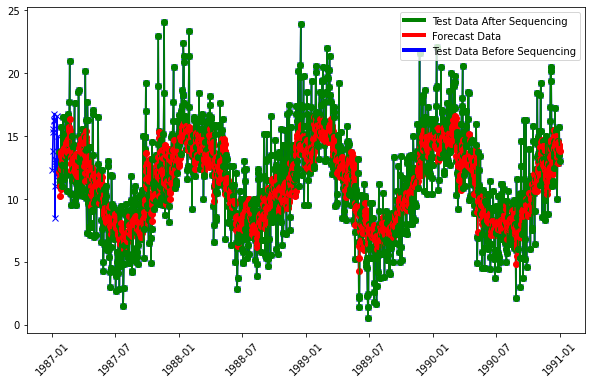

In [54]:
# Use the multi_step_plot function
### BEGIN SOLUTION
data_module.multi_step_plot(original_test_data = test_data_temperature,
                after_sequence_test_data = output_data_temperature ,
                forecast_data = prediction_temperature,
                test_time = test_time_temperature,
                window_size = window_size_temperature ,
                n_step = n_step_temperature,
                details = {},
                original_plot = True)
### END SOLUTION

## Summary
In this tutorial you should have learnt:

1. The flow of using CNN to perform univariate multi-step forecasting<br>

Congratulations, that concludes this lesson.<br>


Please proceed to other notebooks for other types of data in CNN forecasting  <br>

1. ~~*[04 - CNN_Univariate_SingleStep]*~~ *Complete*
2. ~~*[04 - CNN_Univariate_MultiStep]*~~ *Complete*
3. [04 - CNN_Multivariate_Univariate_SingleStep](./04%20-%20CNN_Multivariate_Univariate_SingleStep.ipynb)<br>
4. [04 - CNN_Multivariate_Univariate_MultiStep](./04%20-%20CNN_Multivariate_Univariate_MultiStep.ipynb)<br>

## Reference
1. [Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/)